<a href="https://colab.research.google.com/github/mehdi-or/203B/blob/master/subject_AE%2Bclassifier_PFC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)
import IPython as IP
IP.get_ipython().magic('reset -f')
import numpy as np
from keras.datasets import mnist
from keras import optimizers
from keras.layers import Input, Dense, concatenate, Dropout, Lambda
from keras.utils import to_categorical
#import pydotplus
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas import DataFrame
import os
from scipy import stats
from keras import backend as K
from keras.regularizers import l2
#from keras.wrappers.scikit_learn import KerasClassifier
#from sklearn.model_selection import GridSearchCV
#keras.utils.vis_utils.pydotplus = pydotplus
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
start = time.time()
#%reset -f

Import our data

In [10]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
import h5py
def load_data(subject):
    with h5py.File(r'/content/gdrive/MyDrive/Colab Notebooks/AE with classifier hooked/hrfAll_DLPFC_PETERS.hdf5', 'r') as hdf:
        data0 = hdf.get('items/'+str(subject)+'/rcargs/items/0')
        data = np.array(data0)
        data = np.delete(data,np.where(~data.any(axis=0))[0],axis=1)
        
    labels0 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/AE with classifier hooked/label.csv')
    labels = labels0.values
    return(data, labels)
subjects = range(37,41)
data_dictionary = {}
for subject in subjects:
    data,_ = load_data(subject)
    data_dictionary['subject%s' %subject] = data
_,labels = load_data(subject)

another AE architecture (AE+classifier)

In [12]:
encoding_dim = 100
drop = 0.02
activation_BT = 'linear'
num_epoch = 300
lr = 1e-4
discription = [str(encoding_dim), activation_BT, str(num_epoch), str(lr)]
def nna(encoding_dim):
      # this is our input placeholder for VT (creating a tensor)
      decoding_vox = Input(shape=(X_train.shape[1],), name="PFC-input")

      encoded = Dense(512, activation='tanh', name="encoded_PFC")(decoding_vox)
      encoded= Dropout(drop)(encoded)
      
      Bneck = Dense(encoding_dim, activation=activation_BT, name="Bneck")(encoded)
       
      decoded = Dense(512, activation='tanh', name="decoded-VT")(Bneck)
      decoded= Dropout(drop)(decoded)
      
      classifier1 = Dense(classes.shape[0], activation='softmax', name='classifier')(Bneck)
      decoded = Dense(X_train.shape[1], activation='linear', name="decoded-output")(decoded)
      decoded= Dropout(drop)(decoded)
            
      encoder = Model(decoding_vox, Bneck)
      decoder = Model(decoding_vox, [decoded, classifier1]) # model architecture
      plot_model(decoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
            
      bn_model = Model(inputs= decoder.input, outputs = decoder.get_layer('Bneck').output)
      #just_classifier = Model (inputs=Bneck, outputs=classifier1)
      #weights_classifier = just_classifier.get_weights() # returs a numpy list of weights
      # weights_classifier2 =decoder.layers['classifier'].weights
      # fitting the model and defining loss functiojn for each imput

      names = [weight.name for layer in decoder.layers for weight in layer.weights]
      weights = decoder.get_weights()

      opt = optimizers.Adam(lr)
      decoder.compile(opt, loss=['mean_squared_error', 'categorical_crossentropy'], loss_weights=[1, 0.01])
      return decoder, encoder, Bneck, bn_model, names, weights

import data from subjects

In [14]:
#turning y labels into 1Vsall matrix
classes = np.unique(labels)
num_classes = len(classes)
map_index = np.arange(len(labels))
labels2num = np.zeros((1, len(labels))) 
for item in range(num_classes):
    itemindex = np.array(np.where(labels == classes[item]))
    labels2num[0, itemindex[0, :]] = item   
labels2categ = to_categorical(labels2num[0, :], num_classes=num_classes)



Calling the network

In [ ]:
encoding_dims = [1500, 1000, 500, 250, 200, 150, 100, 60, 50, 30, 20, 15, 10, 5, 2]
#encoding_dims = [5, 2]
class_accuracy = []
for subject in subjects:
  data_train, data_test, y_train, y_test, map_train_index, map_test_index = train_test_split(data_dictionary['subject'+str(subject)], labels2categ, map_index, random_state=42)
  scaler = StandardScaler()
  data_train = scaler.fit_transform(data_train)
  data_test = scaler.transform(data_test)
  data_test = scaler.transform(data_test)
  X_train = data_train
  X_test = data_test
  for encoding_dim in encoding_dims:
    print ('this is for BN dimention of ' + str(encoding_dim))
    decoder, encoder, Bneck, bn_model, names, weights= nna(encoding_dim)
    #for name, weight in zip(names, weights):
      #print(name, weight.shape)

    decoder.fit(X_train, [X_train, y_train], epochs= num_epoch, shuffle=True, validation_data=(X_test,[X_test, y_test]), verbose=0)
    intermediate_layer_model = Model(inputs=decoder.input, outputs=decoder.get_layer('Bneck').output)
    BottleNeck = intermediate_layer_model.predict(X_test)
    bt_features = bn_model.predict(X_test)
    [decoded_VT, classify] = decoder.predict(X_test)
    #in order to plot a fake image for comparison only
    s=int(np.sqrt(decoded_VT.shape[1]))
    decoded_VT0=np.reshape(decoded_VT[:,:s*s],(decoded_VT.shape[0],s,s))
    X_test0 = np.reshape(X_test[:,:s*s],(X_test.shape[0],s,s))
    #plt.imshow(decoded_VT0[0,:,:])
    #plt.figure(2)
    #plt.imshow(X_test0[0,:,:])

    ### logistic classifier ###
    scl = StandardScaler()
    BN_feat_scl = scl.fit_transform(BottleNeck)

    BN_feat = Input(shape=(BottleNeck.shape[1],), name="BN")
    out_class = Dense(classes.shape[0], activation='softmax', name ="output", kernel_regularizer=l2(0.007))(BN_feat)
    classifier = Model(BN_feat, out_class, name='classifier')
    #chossing the learning rate is very important
    opt = optimizers.Adam(lr = 5e-5)
    classifier.compile(opt, loss = 'categorical_crossentropy',  metrics =['accuracy'])

    #labels2categ = to_categorical(labels2num[0, :], num_classes=len(class_number))
    history=classifier.fit(BN_feat_scl, y_test, epochs=500, shuffle=True, validation_split = 0.2, verbose=0)
    class_accuracy.append(history.history['val_accuracy'][-1])
    np.savetxt('/content/gdrive/MyDrive/Colab Notebooks/AE + classifier for fMRI/PFC/s'+ str(subject) + 'BN_dim_' + str(encoding_dim)+ '.csv', BottleNeck, delimiter=',')
    np.savetxt('/content/gdrive/MyDrive/Colab Notebooks/AE + classifier for fMRI/PFC/s'+ str(subject) + 'val_train_dim_' + str(encoding_dim)+ '.csv', history.history['val_accuracy'], delimiter=',')
    plt.figure(1)
    plt.plot(np.asarray(history.history['val_accuracy']))
print(class_accuracy)
np.savetxt('/content/gdrive/MyDrive/Colab Notebooks/AE + classifier for fMRI/person_'+ '41_' + 'accuVsdim_' + str(encoding_dim)+ '.csv', np.array([encoding_dims, class_accuracy]).T, delimiter=',')



In [ ]:
decoded_VT.shape

(900, 2005)

getting weights from diffrent layers

In [ ]:
weights_dictionary = {}
for name, weight in zip(names, weights):
  #print(name, weight.shape)
  weights_dictionary[name %weight] = weight
class_weights = weights_dictionary['classifier/kernel:0']
class_weights_bias = weights_dictionary['classifier/bias:0']
print(class_weights.shape)
print(class_weights_bias.shape)

(100, 40)
(40,)


plotting the decoder result

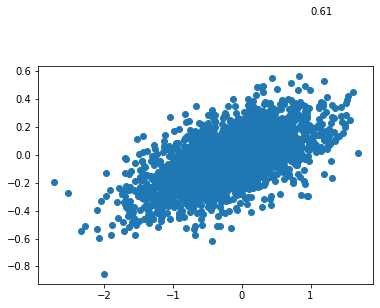

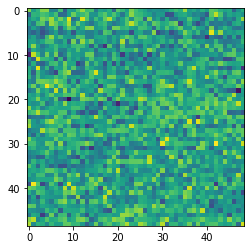

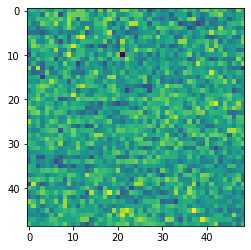

In [ ]:
plt.figure(1)
plt.scatter(decoded_VT[49,:], X_test[49,:])
plt.text(1,1, np.round(np.corrcoef(decoded_VT[49,:], X_test[49,:]),2)[0,1])
plt.figure(2)
plt.imshow(decoded_VT0[49,:])
plt.figure(3)
plt.imshow(X_test0[49,:])

getting access to the BN with two methods and comparing the result


In [ ]:
print(BottleNeck[0:5,0:5])
print(bt_features[0:5,0:5])

plotting the architecture of the model

In [ ]:
plot_model(decoder, show_shapes=True, show_layer_names=True)

logistic classifier

In [ ]:
scl = StandardScaler()
BN_feat_scl = scl.fit_transform(BottleNeck)

BN_feat = Input(shape=(BottleNeck.shape[1],), name="BN")
out_class = Dense(classes.shape[0], activation='softmax', name ="output", kernel_regularizer=l2(0.007))(BN_feat)
classifier = Model(BN_feat, out_class, name='classifier')
#chossing the learning rate is very important
opt = optimizers.Adam(lr = 5e-5)
classifier.compile(opt, loss = 'categorical_crossentropy',  metrics =['accuracy'])

#labels2categ = to_categorical(labels2num[0, :], num_classes=len(class_number))
history=classifier.fit(BN_feat_scl, y_test, epochs=500, shuffle=True, validation_split = 0.2, verbose=0)



Plotting the result from classifier


Text(0.5, 1.0, 'BN features')

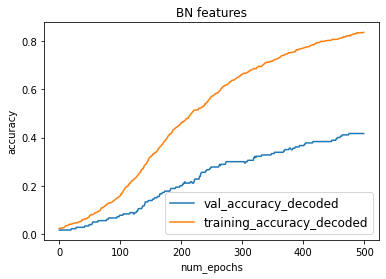

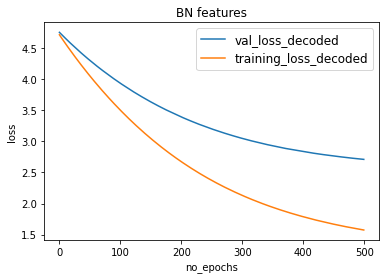

In [ ]:
plt.figure(1)
plt.plot(np.asarray(history.history['val_accuracy']))
plt.plot(np.asarray(history.history['accuracy']))
plt.gca().legend(('val_accuracy_decoded','training_accuracy_decoded'), prop={'size': 12})
plt.xlabel('num_epochs')
plt.ylabel('accuracy')
plt.title('BN features')

plt.figure(2)
plt.plot(np.asarray(history.history['val_loss']))
plt.plot(np.asarray(history.history['loss']))
plt.gca().legend(('val_loss_decoded','training_loss_decoded'), prop={'size': 12})
plt.xlabel('no_epochs')
plt.ylabel('loss')
plt.title('BN features')

using TSNE to reduce the dimension for visualization purposes

In [ ]:
y_test_num = labels2num.T[map_test_index,:]
y_test_num[0:10,:]
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
jet = cm.get_cmap('jet', 40)

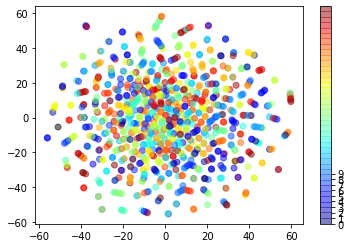

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(BottleNeck)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c= y_test_num, cmap=jet, alpha=.5)
plt.colorbar(ticks=range(10))

plotting the BN features

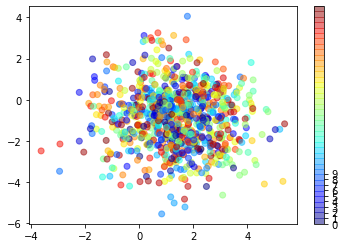

In [ ]:
comp1 = BottleNeck[:,0]
comp2 = BottleNeck[:,1]
#comp3 = BottleNeck[:,2]
cmap = plt.cm.get_cmap('tab10')
plt.scatter(comp1, comp2, c= y_test_num, cmap=viridis, alpha=.5)
plt.colorbar(ticks=range(10))